# Gorouter Throughput Performance

This document summarizes results of a performance test run against Cloud Foundry's L7 HTTP router, known as Gorouter. It may also contain a comparison of two sets of results.

The test results in this report can be reproduced, and this report regenerated by following instructions in the README for [Routing Performance Release](https://github.com/cloudfoundry-incubator/routing-perf-release).

Click the button 'Show Code' below to toggle the display of the code used to generate the graphs below. To compare two sets of results, set `compareDatasets = True`.

In [102]:
from IPython.display import HTML
HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

In [103]:
# To only view one set of data, set the below variable to False and rerun all of the cells.
compareDatasets = True

In [104]:
# SETUP: All of the imports
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import yaml
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

matplotlib.rcParams['figure.figsize'] = 9, 6
matplotlib.rcParams['legend.loc'] = 'best'
matplotlib.rcParams['figure.dpi'] = 120

# We'll need these packages for plotting fit lines
import statsmodels.api as sm
from patsy import dmatrices

from io import StringIO
import re

from IPython.display import Markdown

import os.path

#assert os.path.isfile('cpuStats.csv'), 'Missing CPU stats file "cpuStats.csv"'
assert os.path.isfile('perfResults.csv'), 'Missing performance results file "perfResults.csv"'

def processMetadata(data, defaultValue='default'):
    label=defaultValue
    for info in data:
        for k,v in info.items():
            if k == 'sha':
                label=v
            
    return label
            
if os.path.isfile('metadata.yml'):
    stream = open("metadata.yml", "r")
    metadata = yaml.load_all(stream)
    newDataLabel = processMetadata(metadata, ' ')
        
if compareDatasets:
#     assert os.path.isfile('old_cpuStats.csv'), 'Missing old CPU stats file "old_cpuStats.csv"'
    assert os.path.isfile('old_perfResults.csv'), 'Missing old performance results file "old_perfResults.csv"'
    oldDataLabel = 'before'
    if os.path.isfile('old_metadata.yml'):
        stream = open("old_metadata.yml", "r")
        metadata = yaml.load_all(stream)
        oldDataLabel = processMetadata(metadata, 'before')

## Test Description
This report provides results of a long-running "ramp up" load test in which a fixed number of requests is sent to a static app through Gorouter from one client thread. The number of concurrent threads are then incrementally scaled and at each step the same number of requests are sent across all concurrent threads. As concurrency increases, the time required to send the same number of requests is reduced. 

The tests were run against a standalone Gorouter and a static app running on a raw VM, not against a full Cloud Foundry deployment. The test environment was comprised of two deployments on AWS. We elected to do our testing on Amazon Web Services (AWS) for its network stability.
- We use a modified cf-release manifest to deploy Gorouter and NATS only. Gorouter is run on our default VM type of `c3.large`.
- Load was generated using the [Routing Performance Release](https://github.com/cloudfoundry-incubator/routing-perf-release), which also includes the static backend and a job that registers a configurable number of routes for the backend.


## Gorouter CPU Load over Time

The following plot shows a summary of the CPU load over the duration of the test run. Here are some key points to note when looking at this data:

  - Each CPU sample collected is highly variable; this is characteristic of CPU load on Gorouter when it is handling requests. For purpose of graphing, the test results have been downsampled in order to smooth out variations that happen over a short periods of time. The mean of each sample is represented in the plot to depict the average CPU load over time. As an example, while the plots may plateau before reaching 100% CPU load, actual CPU load during the sample may have fluctuated between 80% and 100% CPU load.
  - When we test with a large routing table, as when `http_route_populator` is configured to register 100,000 routes, we see many tall spikes that show up periodically every 60 seconds. These spikes represent processing of the large number of route registration messages. When `http_route_populator` is configured to register only one route, fewer spikes are present.
  - It's possible for the plot to be cut off before the edge of the graph. This indicates where the performance test run finished.
  - There may be many jagged small spikes throughout the plot. This corresponds to the starting and stopping of the load tests each time concurrency is incremented.

To avoid degradation of service (significant increases in latency) Gorouter should scaled vertically and/or horizontally before CPU approaches maximum. The graphs below demonstrate that as CPU approaches the plateau, latency begins to increase to the point where throughput plateaus. Past this point throughput does not increase with added load; this only results in added latency. In general we recommend scaling Gorouter when CPU reaches 60-70%.

In [105]:
# To increase or decrease the number of results in the plotted sample windows, change the following variable and rerun all of the cells.
resampleFrequency = 5

In [106]:
# def processCpuData(data):
#     meanData = data.resample('{0}s'.format(resampleFrequency)).mean()
#     meanData = meanData.reset_index()
#     meanData = meanData.set_index(meanData.index.values * resampleFrequency)
#     return meanData

# cpuData = pd.read_csv('cpuStats.csv', parse_dates=['timestamp'], index_col=['timestamp'])
# cpuMeanData = processCpuData(cpuData)

# if compareDatasets:
#     oldCpuData = pd.read_csv('old_cpuStats.csv', parse_dates=['timestamp'], index_col=['timestamp'])
#     oldCpuMeanData = processCpuData(oldCpuData)

# Markdown("The following CPU data is sampled over {0} second windows.".format(resampleFrequency))

In [107]:
# fig, ax = plt.subplots()
# ax = cpuMeanData.plot(ax=ax, y='percentage', c='b')
# if compareDatasets:
#     ax = oldCpuMeanData.plot(ax=ax, y='percentage', c='r')
#     ax.legend([newDataLabel, oldDataLabel])
# else:
#     ax.legend([newDataLabel])
# ax.set_ylabel('CPU percentage')
# ax.set_xlabel('Time since benchmark started (seconds)')
# ax.set_title('Mean CPU percentage over time')
# plt.show()

## Gorouter Throughput over Time

The following plot shows a summary of throughput performance over the duration of the test run. Here are some key points to note when looking at this data:

- When we test with a large routing table, as when `http_route_populator` is configured to register 100,000 routes, we see many spikes and few troughs in this graph. These represent processing of the large number of route registration messages. When `http_route_populator` is configured to register only one route, far less variability is observed.
- It's possible for the plot to be cut off before the edge of the graph. This indicates where the performance test run finished.
- The throughput plot ramps up as concurrency is scaled and then plateaus. The point at which throughput plateaus should correspond with where CPU plateaus.

The throughput level at which the plot plateaus is the absolute maximum throughput that each Gorouter VM will be able to handle. As can be seen in the graph below "Headroom Plot", by the time throughput reaches this point latency will have spiked to unacceptable levels. See comments above for "CPU Over Time" regarding scaling Gorouter to prevent  degradation of service.

In [108]:
def readThroughputData(filename):
    with open(filename) as f:
        data = f.read()
    # Get locations of start-time,response-time headers in file
    header_idxs = [m.start() for m in re.finditer('start-time,response-time', data)]
    header_idxs.append(len(data))
    prev = header_idxs[0]
    
    df = pd.DataFrame()
    # Read each section delimited by the csv headers
    for cur in header_idxs[1:]:
        dfSection = pd.read_csv(StringIO(data[prev:cur]), parse_dates=['start-time'])
        df = df.append(trimEdges(dfSection))
        prev = cur
    # Reset the index because it is a Frankenstein's monster of smaller indexes
    df = df.reset_index().drop('index', axis=1)
    return df
    
def trimEdges(data):
    indexes = data.set_index('start-time').resample('1S').aggregate(lambda x: 1).index
#     print(indexes)
#     print(indexes[1])
    testStartTime = indexes[1]
    testEndTime = indexes[-2]
    return data[(data['start-time'] >= testStartTime) & (data['start-time'] <= testEndTime)]
    
def processThroughputData(data):
    buckets = data.set_index('start-time')['response-time'].resample('1S')
    throughputData = buckets.aggregate({'throughput': lambda x: np.nan if x.count() == 0 else x.count()})
    throughputData = throughputData.reset_index()
    throughputData = throughputData.fillna(method='ffill')
    return buckets, throughputData
    
goData = readThroughputData('perfResults.csv')
throughputBuckets, throughputData = processThroughputData(goData)

if compareDatasets:
    oldGoData = readThroughputData('old_perfResults.csv')
    oldThroughputBuckets, oldThroughputData = processThroughputData(oldGoData)

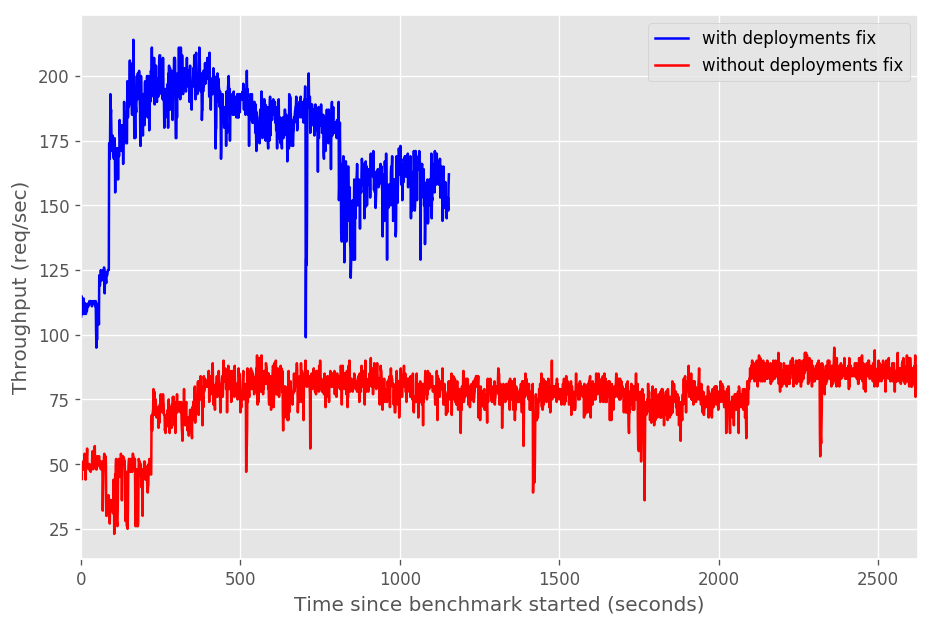

In [109]:
fix, ax = plt.subplots()
ax = throughputData.plot(ax=ax, y='throughput', c='b')
if compareDatasets:
    ax = oldThroughputData.plot(ax=ax, y='throughput', c='r')
    ax.legend([newDataLabel, oldDataLabel])
else:
    ax.legend([newDataLabel])
ax.set_ylabel('Throughput (req/sec)')
ax.set_xlabel('Time since benchmark started (seconds)')
plt.show()

## Throughput Headroom Plot

This graph plots throughput versus latency to illustrate the cost of latency as throughput approaches a limit. This graph provides Gorouter's maximum throughput to remain within a given target latency. The CPU graph above shows the CPU load at this throughput. An operator can monitor CPU, as well as latency, and scale Gorouter vertically or horizontally to remain within latency targets as application request load increases.
In order to target throughput for application request load, divide the targeted throughput number by the throughput at the target latency and round up to the nearest whole number. This is the minimum amount of Gorouter instances (`c3.large`) necessary to meet performance objectives.

For example, in order to achieve a targeted throughput of 10,000 requests per second at 20 milliseconds of average response time (latency), and if the point in the Headroom plot corresponds to 2,500 requests per second (throughput), then at least four Gorouter VMs are required to meet performance objectives.

In [110]:
goData['throughput'] = throughputBuckets.transform(len).reset_index()['response-time']
goData.columns = ['start-time', 'latency', 'throughput']

if compareDatasets:
    oldGoData['throughput'] = oldThroughputBuckets.transform(len).reset_index()['response-time']
    oldGoData.columns = ['start-time', 'latency', 'throughput']

In [111]:
def generateFitLine(data):
    y, x = dmatrices('latency ~ throughput', data=data, return_type='dataframe')
    fit = sm.GLM(y, x, family=sm.families.InverseGaussian(sm.families.links.inverse_squared)).fit()

    domain = np.arange(data['throughput'].min(), data['throughput'].max())
    predictionInputs = np.ones((len(domain), 2))
    predictionInputs[:,1] = domain
    fitLine = fit.predict(predictionInputs)
    return domain, fitLine

domain, goFitLine = generateFitLine(goData)

if compareDatasets:
    oldDomain, oldGoFitLine = generateFitLine(oldGoData)

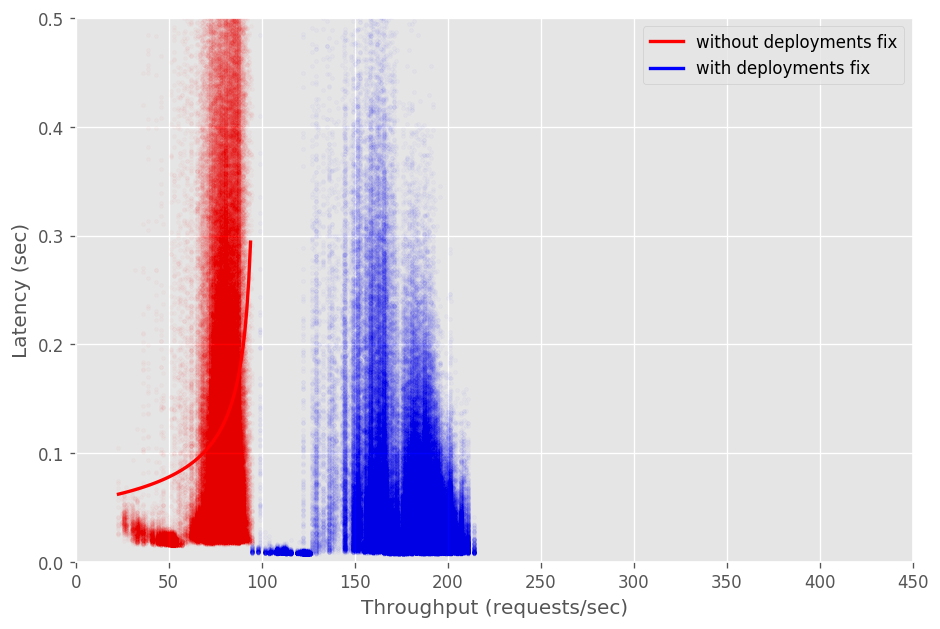

In [112]:
fig, ax = plt.subplots()

if compareDatasets:
    ax = oldGoData.plot(ax=ax, kind='scatter', x='throughput', y='latency', c='r', marker='.', alpha=0.02)
    ax.plot(oldDomain, oldGoFitLine, c='r', lw=2) # Plot the fit line

# Change the value of `c` to change the color. http://matplotlib.org/api/colors_api.html
ax = goData.plot(ax=ax, kind='scatter', x='throughput', y='latency', c='b', marker='.', alpha=0.02)
ax.plot(domain, goFitLine, c='b', lw=2) # Plot the fit line

if compareDatasets:
    ax.legend([oldDataLabel, newDataLabel])
else:
    ax.legend([newDataLabel])
# To update x & y axis range change the parameters in function set_(x/y)lim(lower_limit, uppper_limit) 
ax.set_ylim(0,0.5)
ax.set_xlim(0,450)
plt.xlabel('Throughput (requests/sec)')
plt.ylabel('Latency (sec)')
#plt.title('Headroom plot', y=1.05)
plt.show()